In [ ]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np

# Load the CORINE vector data
corine_path = "path/to/corine_ile_de_france.gpkg"  # Replace with your file path
corine_data = gpd.read_file(corine_path)

# Define the output TIFF parameters (match Sentinel-2 resolution and extent)
output_resolution = 10  # 10 meters for Sentinel-2
output_crs = "EPSG:32631"  # UTM zone 31N for Île-de-France (adjust as needed)
output_bounds = corine_data.total_bounds  # Use the extent of the CORINE data

# Create an output transform
transform = rasterio.transform.from_origin(
    output_bounds[0], output_bounds[3], output_resolution, output_resolution
)

# Rasterize the vector data
shapes = [(geom, value) for geom, value in zip(corine_data.geometry, corine_data["CODE_18"])]
rasterized = rasterize(
    shapes,
    out_shape=(int((output_bounds[3] - output_bounds[1]) / output_resolution),
               int((output_bounds[2] - output_bounds[0]) / output_resolution)),
    transform=transform,
    fill=0,  # Background value for no-data
    dtype=np.uint8,
)

# Save the rasterized data as a TIFF file
output_path = "path/to/corine_ile_de_france.tif"
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=rasterized.shape[0],
    width=rasterized.shape[1],
    count=1,
    dtype=rasterized.dtype,
    crs=output_crs,
    transform=transform,
) as dst:
    dst.write(rasterized, 1)

print(f"Rasterized TIFF saved to {output_path}")

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from rasterio.plot import show

# Path to Sentinel-2 TIFF file
file_path = r"H:/Downloads/Browser_images (2)/2023-02-07-00_00_2023-02-07-23_59_Sentinel-2_L1C_False_color.tiff"

# Open the image
with rasterio.open(file_path) as src:
    img = src.read()
    profile = src.profile
    transform = src.transform


# Assuming bands are: 0=Red, 1=Green, 2=Blue, 3=NIR, 
red, green, blue, nir = img[0], img[1], img[2], img[3]

# Stack features (add more bands if available)
features = np.column_stack((red.flatten(), green.flatten(), blue.flatten(), nir.flatten()))

# Normalize features (if needed)
features = features / 10000  # Scale reflectance values

# Load real labeled data (replace this with actual labeled data)
# Example: labels = np.load("labels.npy")
labels = np.random.choice([0, 1, 2, 3], features.shape[0])  # Replace with real labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Predict land cover for entire image
predicted = clf.predict(features).reshape(red.shape)

# Plot Classification Map
plt.figure(figsize=(10, 10))
plt.imshow(predicted, cmap="tab10")
plt.colorbar(label="Land Cover Classes")
plt.title("Land Cover Classification (RGB + NIR + SWIR)")
plt.axis("off")
plt.show()

Model Accuracy: 0.25
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.33      0.30       241
           1       0.22      0.20      0.21       251
           2       0.25      0.29      0.27       235
           3       0.26      0.21      0.23       273

    accuracy                           0.25      1000
   macro avg       0.25      0.26      0.25      1000
weighted avg       0.25      0.25      0.25      1000



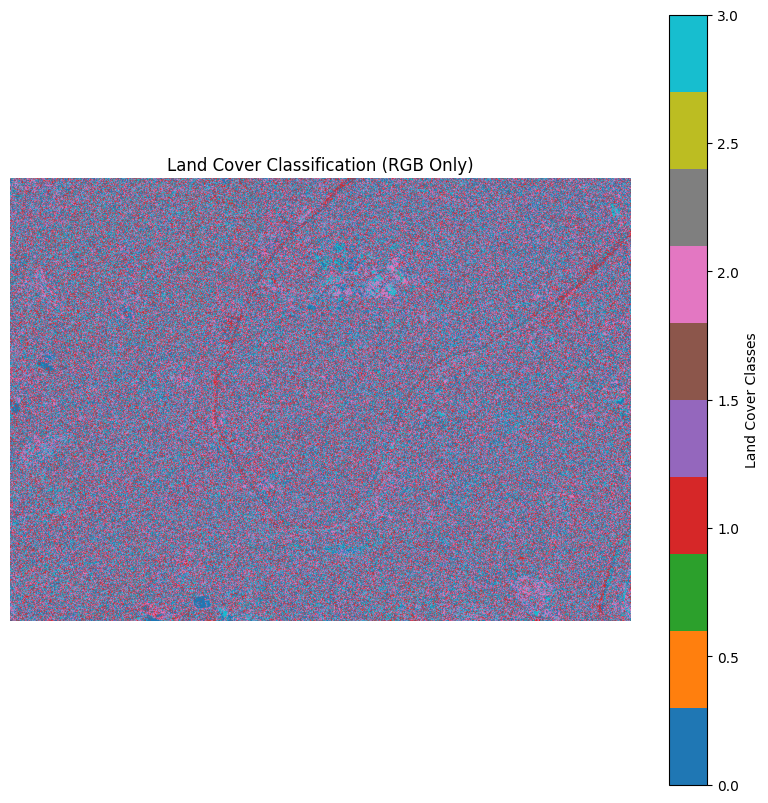

In [16]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from rasterio.plot import show

# Path to Sentinel-2 TIFF file
file_path = r"H:/Downloads/2023-02-07-00_00_2023-02-07-23_59_Sentinel-2_L1C_True_color.tiff"

# Open the image
with rasterio.open(file_path) as src:
    img = src.read()
    profile = src.profile
    transform = src.transform

# Assuming bands are: 0=Red, 1=Green, 2=Blue
red, green, blue = img[0], img[1], img[2]

# Flatten the arrays for ML training
features = np.column_stack((red.flatten(), green.flatten(), blue.flatten()))

# Generate synthetic labels for training (manually labeled or use sample points)
num_samples = 5000
labels = np.random.choice([0, 1, 2, 3], num_samples)  # 0=Forest, 1=Urban, 2=Water, 3=Bare Soil
sample_indices = np.random.choice(features.shape[0], num_samples, replace=False)

X_train, X_test, y_train, y_test = train_test_split(features[sample_indices], labels, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict land cover for entire image
predicted = clf.predict(features).reshape(red.shape)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Classification Map
plt.figure(figsize=(10, 10))
plt.imshow(predicted, cmap="tab10")
plt.colorbar(label="Land Cover Classes")
plt.title("Land Cover Classification (RGB Only)")
plt.axis("off")
plt.show()
